# __WATER MLIP MD simulations__
Objective: generate enough sampling to determine if the experimental solvent-dependence of COSAN is observed using three different uMLIP models: UMA-small, MACE-MP-0b2 and ORB-v3. 

Secondary objective: See if in sampling the lack of rotational invariance of ORB models is diffuminated. Inspired by the ETH Zürich team regarding rotational invariance and direct force prediction. 

### __Imports & Functions__

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase.visualize import view
from ase.build import molecule
from ase.io import write, read
from ase.io import Trajectory, trajectory
from ase import build
from ase.data.pubchem import pubchem_atoms_search

import ase.units as units
from ase import Atoms
from ase.calculators.tip3p import TIP3P, angleHOH, rOH
from ase.constraints import FixBondLengths
from ase.io.trajectory import Trajectory
from ase.io.trajectory import TrajectoryReader
from ase.md import Langevin, VelocityVerlet
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.calculators.tip3p import angleHOH, rOH
import pickle
import ase.io
from tqdm import tqdm

try:
    import cmocean
    cmap = cmocean.cm.balance   
except:
    cmap = 'seismic'

In [34]:
def analyze_energies(sim_path):
    
    # obtain all (unordered) trajectories in sim_path
    log_list = [x for x in os.listdir(sim_path) if '.log' in x]

    global_time = []
    global_etot = []
    global_epot = []
    global_ekin = []
    time_track = 0
    # for each traj file, obtain the dihedrals
    for i in range(len(log_list)):
        #print(os.path.join(sim_path, log_list[i]))
        
        # load the data in the .log file
        raw_data = np.loadtxt(fname=os.path.join(sim_path, log_list[i]), skiprows=1)
        if i == 0:
            time_data = raw_data[:, 0]
            print(time_data)
            dt = time_data[1] - time_data[0]
            length = time_data[-1]

        global_etot.append(raw_data[:, 1])
        global_epot.append(raw_data[:, 2])
        global_ekin.append(raw_data[:, 3])
        time_serie = np.arange(time_track, time_track+length+dt, step=dt)
        #print(time_serie)
        global_time.append(time_serie)
        time_track += length

    # pool all dihedrals 
    time = np.array(global_time).flatten()
    etot_data = np.array(global_etot).flatten()
    epot_data = np.array(global_epot).flatten()
    ekin_data = np.array(global_ekin).flatten()


    '''
    # load the data in the .log file
    raw_data = np.loadtxt(fname=log_path, skiprows=1)
    time_data = raw_data[:, 0]
    etot_data = raw_data[:, 1]
    epot_data = raw_data[:, 2]
    ekin_data = raw_data[:, 3]
    '''
    
    # plot
    # define the figure
    n_cols = 3
    n_rows = 1
    fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(3.5*n_cols, 3.5*n_rows))
    ax1, ax2, ax3 = axes[0], axes[1], axes[2]


    # kin
    ax1.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
    ax1.plot(time, ekin_data, label=r'$\textnormal{kinetic energy}$', color='deeppink', alpha=0.9)
    ax1.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{kinetic energy}\;(\textnormal{eV})$')
    ax1.legend(loc='best')

    # pot
    ax2.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
    ax2.plot(time, epot_data, label=r'$\textnormal{potential energy}$', color='darkgreen', alpha=0.9)
    ax2.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{potential energy}\;(\textnormal{eV})$')
    ax2.legend(loc='best')

    # total
    ax3.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
    ax3.plot(time, etot_data, label=r'$\textnormal{total energy}$', color='darkviolet', alpha=0.9)
    ax3.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{total energy}\;(\textnormal{eV})$')
    ax3.legend(loc='best')

    plt.tight_layout()
    plt.savefig(os.path.join(sim_path, 'energies.png'), dpi=300)
    plt.show(fig)




In [35]:
def polar_kde(tp, gt, gp, bw=0.1):
    """ Computes a KDE for polar coordinates. 
    
    param tp: np.array((i,2)) array of (theta, phi) values for the samples
    param gt: np.array(ntheta) grid of cos(theta) values
    param gp: np.array(nphi) grid of phi values
    param bw: float bandwidth
    
    returns the grid of properly-symmetrized Gaussian values, accumulated over the samples
    """
    
    # computes the theta grid. this should have hard walls at [-1,1] which we implement with folded Gaussians
    gx = np.exp(-0.5*((tp[:,0][:,np.newaxis]-gt[np.newaxis,:]) / bw)**2)
    gx += np.exp(-0.5*((2-tp[:,0][:,np.newaxis]-gt[np.newaxis,:]) / bw)**2)
    gx += np.exp(-0.5*((-2-tp[:,0][:,np.newaxis]-gt[np.newaxis,:]) / bw)**2)
    gx /= np.sqrt(2*np.pi)*bw
    
    # computes the phi grid. this is periodic in [0, 2*pi] which we implement with one periodic image
    gy = np.exp(-0.5*((tp[:,1][:,np.newaxis]-gp[np.newaxis,:]) / bw)**2)
    gy += np.exp(-0.5*((2*np.pi+tp[:,1][:,np.newaxis]-gp[np.newaxis,:]) / bw)**2)
    gy += np.exp(-0.5*((-2*np.pi+tp[:,1][:,np.newaxis]-gp[np.newaxis,:]) / bw)**2)
    gy /= np.sqrt(2*np.pi)*bw
    
    return np.einsum("it,ip->tp", gx, gy)


def orientational_distribution(filename, kde_size=100, bandwidth=0.1, block_size=200, progress=(lambda x: x)):
    """
    Computes the distribution of the absolute orientation of water molecules in an ASE-readable file.
    The distribution is computed over the cosine of the polar angle and the azimuthal angle, and 
    divided by 4pi so that in a uniformly-distributed system it'll have a value of 1 everywhere.
    
    param filename: string, filename
    param kde_size: int, the grid will be (kde_size+1, 2*kde_size+1) along the (cos(theta), phi) directions
    param bandwidth: the bandwidth for the density estimation
    """
    
    grid = np.zeros(shape=(kde_size+1, 2*kde_size+1))
    grid_costheta = np.linspace(-1, 1, kde_size+1)
    grid_phi = np.linspace(np.pi*0.5/kde_size, 2*np.pi*(1-0.5/kde_size), 2*kde_size+1)    
    frame = ase.io.read(filename, "0")
    thetaphi = np.zeros(shape=(len(frame)//3, 2))
    nsamples = 0
    blocks = []
    for i, frame in progress(enumerate(ase.io.iread(filename))):
    
        # computes in one go the orientation vector for every water molecule (mid-point between H minus O)
        u = 0.5*(frame.positions[1::3]+frame.positions[2::3])-frame.positions[0::3]
        u /= np.sqrt((u**2).sum(axis=1))[:, np.newaxis]
        
        # converts in cos theta, phi
        thetaphi[:,0] = u[:,2]
        thetaphi[:,1] = np.arctan2(u[:,1], u[:,0])
        
        # computes the KDE for this frame and accumulates
        grid += polar_kde(thetaphi, grid_costheta, grid_phi, bandwidth)
        nsamples += len(thetaphi)
        
        # store blocks to compute uncertainty on the distribution
        if (i+1)%block_size == 0:
            blocks.append(grid*4*np.pi/nsamples)
            grid *= 0
            nsamples = 0
            
    if len(blocks)==0:  # if there's just one block, store it for further processing
        blocks.append(grid*4*np.pi/nsamples)
        
    blocks = np.asarray(blocks)
    print(blocks.shape)
    
    return (grid_phi, grid_costheta, blocks.mean(axis=0), blocks.std(axis=0)/np.sqrt(blocks.shape[0]))


def join_ase_traj(sim_path, traj_name):

    traj_list = [x for x in os.listdir(sim_path) if '.traj' in x]
    traj_path_list = [os.path.join(sim_path, traj) for traj in traj_list]
    all_trajs = []
    for traj_fname in traj_path_list:
        all_trajs += read(traj_fname, index=':')
    write(os.path.join(sim_path, traj_name), all_trajs)


def analyze_water_traj(sim_path, ngrid, bw, block):

    # constants
    dat_name = 'orientation.dat'
    traj_name = 'complete_traj.traj'
    pdf_name = 'orientation_PDF.pdf'

    dat_path = os.path.join(sim_path, dat_name)
    plot_path = os.path.join(sim_path, pdf_name)
    traj_path = os.path.join(sim_path, traj_name)
    
    
    # join the all trajs files to a single trajectory file
    join_ase_traj(sim_path, traj_name)

    # perform the analysis
    grids = orientational_distribution(traj_path, ngrid, bw, block, progress=tqdm)

    # save files
    print(f'exporting raw MD plot data @ {dat_path}')
    np.savetxt(dat_path, grids[2])   

    # load data 
    md_data = np.loadtxt(dat_path)

    # plot
    fig, ax = plt.subplots(1,1,figsize=(4.5,3.5), constrained_layout=True)

    xgrid = np.linspace(-1,1,md_data.shape[0])
    ygrid = np.linspace(0,2*np.pi,md_data.shape[1])
    mesh = ax.pcolormesh(xgrid, ygrid, -np.log(md_data.T), vmin=-0.4, vmax=0.4, cmap=cmap, rasterized="True")

    # colorbar
    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical')
    cbar.set_label(r"$F$ / $k_{\mathrm{B}} T$", rotation=90, labelpad=5, verticalalignment='center')
    custom_ticks = np.linspace(-0.4, 0.4, 5)            
    custom_labels = [f"${tick:.2f}$" for tick in custom_ticks]
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels(custom_labels)

    # custom y ticks
    custom_ticks = [np.pi*i for i in np.linspace(0, 2, 3)]
    custom_labels = ["0", r"$\pi$", r"$2\pi$"]
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_labels)

    ax.set_xlabel(r"$\cos\theta$")
    ax.set_ylabel(r"$\phi$")
    labelbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='square,pad=0.2')

    # save
    #fig.tight_layout()
    fig.savefig(plot_path)

[  0.    0.1   0.2 ...  99.8  99.9 100. ]


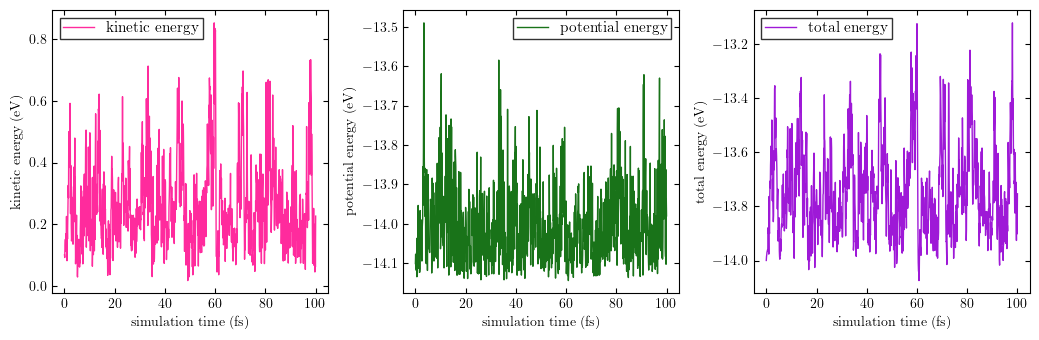

1001it [00:00, 4193.13it/s]


(10, 101, 201)
exporting raw MD plot data @ /Users/sergiortizropero/TFG_phys/NNPs_TFG/COSAN/simulations/WATER/single_ORB_100.0/orientation.dat


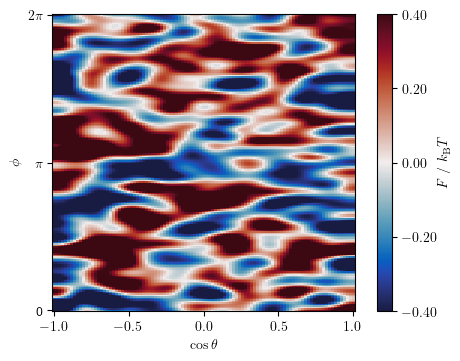

In [36]:
# PERFORM THE ACTUAL ANALYSIS
sim_path = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/COSAN/simulations/WATER/single_ORB_100.0'

ngrid = 100
block = 100
bw = 0.1


analyze_energies(sim_path)
analyze_water_traj(sim_path, ngrid, bw, block)

# __Water MD Analysis__
Analyze the polar distribution using different uMLIPs, reproduced from [this paper](). 

In [ ]:
# visualize
water_box_pdb = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/COSAN/simulations/water_mds/water_box.pdb'
water_box = read(water_box_pdb)
view(water_box, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

In [8]:
# visualize the traj
traj_path = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/COSAN/simulations/water_mds/solvated_ORB_1.0/solvated_ORB_1.0_1.traj'

load_traj = Trajectory(traj_path, 'r')
view(load_traj, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_orbital/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/env